### IRX Factor

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

price = pd.read_parquet(
    '../Data/US_stock_Price.parquet',
).resample('W-FRI').last()

In [38]:
import yfinance as yf
irx = yf.download(
    '^IRX',
    start = '1989-01-01',
    progress = False
)

In [39]:
irx_diff = (irx['Close'].resample('W-FRI').last() * 0.01 / 52).diff()

In [40]:
price_ret = price.pct_change()

/var/folders/1q/pl9tj55n57s9jg28npxw61n80000gn/T/ipykernel_26980/1882691314.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  price_ret = price.pct_change()


In [41]:
oil_excess = price_ret - pd.DataFrame(irx_diff.loc['1990':]).values

In [42]:
price = pd.read_parquet(
    '../Data/US_stock_Price.parquet',
)
price_ret = price.pct_change()

/var/folders/1q/pl9tj55n57s9jg28npxw61n80000gn/T/ipykernel_26980/2331620672.py:4: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  price_ret = price.pct_change()


In [43]:
from tqdm import tqdm
up_30per = dict()
down_30per = dict()

mean_excess = pd.DataFrame(
    index = price_ret.index,
    columns = ['Up 30per', 'Down 30per']
)

for i in tqdm(zip([f'{year}-06' for year in range(1990, 2025)], [f'{year}-05' for year in range(1991, 2026)])) :
    length = int(len(oil_excess.loc[i[0]:i[1]].mean().sort_values(ascending = False).dropna()) * 0.3)
    up_30per[i[0]] = oil_excess.loc[i[0]:i[1]].mean().sort_values(ascending = False).dropna().iloc[:length].index.tolist()
    down_30per[i[0]] = oil_excess.loc[i[0]:i[1]].mean().sort_values(ascending = True).dropna().iloc[:length].index.tolist()
    
    mean_excess.loc[i[0]:i[1], 'Up 30per'] = price_ret.loc[i[0]:i[1], up_30per[i[0]]].mean(axis = 1).values
    mean_excess.loc[i[0]:i[1], 'Down 30per'] = price_ret.loc[i[0]:i[1], down_30per[i[0]]].mean(axis = 1).values

35it [00:02, 16.33it/s]


In [44]:
irx_factor = mean_excess['Up 30per'] - mean_excess['Down 30per']

<Axes: xlabel='Date'>

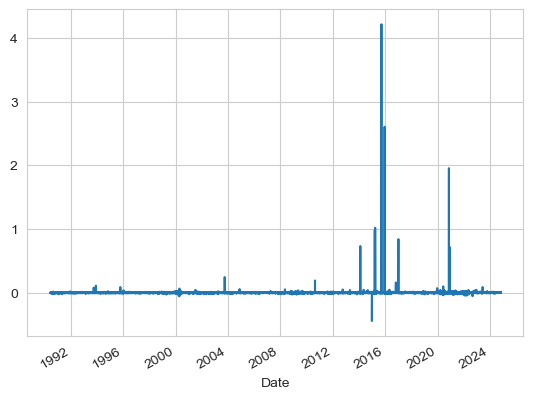

In [45]:
irx_factor.plot()

In [47]:
mean_excess

,Up 30per,Down 30per
Date,,
1990-01-02,NaN,NaN
1990-01-03,NaN,NaN
1990-01-04,NaN,NaN
1990-01-05,NaN,NaN
1990-01-08,NaN,NaN
...,...,...
2024-10-25,0.001485,-0.002296
2024-10-28,0.021218,0.01059
2024-10-29,0.001531,-0.009331


In [46]:
pd.DataFrame(irx_factor).to_parquet('../Data/IRX_Factor.parquet')